In [89]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from kmapper import jupyter

import numpy as np
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.linalg import svd
from numpy import linalg as LA
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
from random import randint
import umap
import kmapper as km
from kmapper.plotlyviz import plotlyviz
import networkx as nx
from community import best_partition # this is not part of networkx
import os.path

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma

def usvd(df):
    data = df.fillna(0).values
    '''rescale observed data to (-1,1) range and output the new matrix z'''
    i = np.nonzero(data)[0]
    j = np.nonzero(data)[1]
    x = data[np.nonzero(data)]
    a = x.min()
    b = x.max()
    x = (x - (a+b)*0.5)/((b-a)*0.5)
    z = csc_matrix((x,(i,j)), data.shape).todense()
    '''svd'''
    u, s, vt = svd(z,check_finite=True,full_matrices=False)
    '''truncate svd'''
    p = np.count_nonzero(z)*1.0/z.size # probability estimated from data pattern
    threshold = 2.01*np.sqrt(p*max(z.shape)) # threshold obtained by usvd paper
    ix = np.where( s > threshold )
    k = ix[0].max()+1
    w = np.dot(u[:,:k], np.dot(np.diag(s[:k]), vt[:k,:]))
    '''clean'''
    w[w < -1] = -1
    w[w > 1] = 1
    w = w*(b-a)*0.5+(a+b)*0.5
    new_df = pd.DataFrame(w,index=df.index,columns=df.columns)
    return new_df, k

In [101]:
# %matplotlib
datadir = '/home/garner1/Work/dataset/SSF/prostate-twelve/'
section = 'P4.3'

filename = datadir+section+'.tsv'
df = pd.read_csv(filename, sep='\t', header=0, index_col=0) # read the gene X position count-matrix

spatialCoord = [w.split('x') for w in list(df.columns.values)]
spatialCoord = [map(int,pairs) for pairs in spatialCoord]

i = [s[0] for s in spatialCoord]
j = [s[1] for s in spatialCoord]

value = [1]*len(i)

'''Visualize the sample geometry'''
# plt.figure()
# mat = coo_matrix((value, (i, j)), [max(i)+1, max(j)+1]).todense()
# sns.heatmap(mat, annot=False)

# df, k = usvd(df)
# print "The estimated rank of the data is: "+str(k)

dfnorm = df.div( df.sum(axis=0)+1, axis=1 ) #normalize to probabilities the transcriptome at each position
data = dfnorm.fillna(0).transpose().values

'''Evaluate spatial distance from a point'''
# from sklearn.metrics.pairwise import euclidean_distances
# spatialCoord = [w.split('x') for w in list(df.columns.values)]
# spatialCoord = [map(int,pairs) for pairs in spatialCoord]
# X = [[s[0],s[1]] for s in spatialCoord]
# origin = [0, 0]
# distances = euclidean_distances(X, [origin]) # get distance to origin

'''Plot spatial distribution of RC for a given gene'''
# for gene in ["SPON1 ","TFF3 ","SPINK1 "]: # leave a space to make unique the name
# # for gene in ["SPON1 "]: # leave a space to make unique the name
#     getGene = df[df.index.str.contains(gene)==True]
# getGene

df1 = df.filter(like="SPON1 ", axis=0)
df2 = df.filter(like="TFF3 ", axis=0)
df3 = df.filter(like="SPINK1 ", axis=0)

df1 = df1.append(df2, ignore_index=False)
df1 = df1.append(df3, ignore_index=False)
df1
#     spatialCoord = [w.split('x') for w in list(getGene.index.values)]
#     spatialCoord = [map(int,pairs) for pairs in spatialCoord]
#     i = [s[0] for s in spatialCoord]
#     j = [s[1] for s in spatialCoord]

#     mat = coo_matrix((getGene.values.ravel(), (i, j)), [max(i)+1, max(j)+1]).todense()

,10x10,11x10,12x10,13x10,14x10,15x10,16x10,17x10,18x10,19x10,...,13x9,14x9,15x9,16x9,17x9,18x9,19x9,20x9,5x9,8x9
SPON1 ENSG00000262655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TFF3 ENSG00000160180,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The estimated rank of the data is: 2


RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3snaG92ZXJpbmZvJzogJ25vbmUnLAogICAgICAgICAgICAgICdsaW5lJzogeydjb2xvcic6ICdyZ2IoMTgwLDE4MCwxODApJywgJ3dpZHRoJzrigKY=


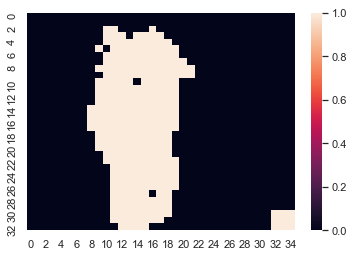

In [88]:
'''Initialize'''
mapper = km.KeplerMapper(verbose=0)
metric = 'euclidean'
'''Fit to and transform the data'''
n_components = 3
random_state = 157
projected_data = mapper.fit_transform(data, 
                                      projection=umap.UMAP(n_neighbors=15,min_dist=0.1,
                                                            n_components=n_components,
                                                            metric=metric,
                                                            random_state=random_state))

'''Create dictionary called 'graph' with nodes, edges and meta-information'''
nr_cubes = 10
graph = mapper.map(projected_data, data,clusterer=DBSCAN(eps=0.5, 
                                                         min_samples=1, 
                                                         metric=metric),
                   coverer=km.Cover(nr_cubes=nr_cubes, overlap_perc=0.5))

'''Visualize it'''
plotlyviz(graph, color_function=distances.ravel(), dashboard=False, graph_data=False, title=str(section)) 

In [54]:
'''Visualize it'''
# html = mapper.visualize(graph, 
#                         path_html=section+".UMAP.cubes"+str(nr_cubes)+".components"+str(n_components)+".rndstate"+str(random_state)+"_mapper_output.html",
#                         title=filename,
#                         color_function=distances.ravel())

# jupyter.display(path_html=section+".UMAP.cubes"+str(nr_cubes)+".components"+str(n_components)+".rndstate"+str(random_state)+"_mapper_output.html")

plotlyviz(graph, color_function=distances.ravel(), dashboard=False, graph_data=False, title=str(section)) 

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3snaG92ZXJpbmZvJzogJ25vbmUnLAogICAgICAgICAgICAgICdsaW5lJzogeydjb2xvcic6ICdyZ2IoMTgwLDE4MCwxODApJywgJ3dpZHRoJzrigKY=


In [103]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

im = Image.open('/home/garner1/Work/dataset/SSF/prostate-twelve/images/P1_2.tiff')
im.show()